In [1]:
import torch
from torch import nn
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
np.random.seed(314)

Mounted at /content/drive


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
train_loader = torch.load('drive/MyDrive/Colab_Notebooks/NN_project/train_loader.pth')
valid_loader = torch.load('drive/MyDrive/Colab_Notebooks/NN_project/valid_loader.pth')
test_loader = torch.load('drive/MyDrive/Colab_Notebooks/NN_project/test_loader.pth')

In [22]:
input_size = 29 #17
sequence_size = 58 # max
num_layers = 3
hidden_size = 16
num_epochs = 20
batch_size = 64
eta = 0.01

In [23]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(LSTM, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    out, _ = self.lstm(x, (h_0, c_0))
    out = self.fc(out)
    out = self.sigmoid(out)

    return out


In [6]:
def test_me(model, test_loader):
  accuracy = 0
  loss = 0
  for i, dt in enumerate(test_loader):
    texts = dt[:,:,0:-1].to(device)
    labels = dt[:,:,-1].to(device)
    outputs = model(texts.float())
    outputs = outputs.squeeze()
    loss += criterion(outputs, labels.float())

    pred = torch.round(outputs)
    a = pred==labels
    accuracy += torch.mean(a.float())

  mean_accuracy = accuracy / len(test_loader)
  mean_loss = loss / len(test_loader)

  return mean_accuracy, mean_loss

In [24]:
model = LSTM(input_size, hidden_size, num_layers).to(device)
model = model.float()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=eta)  

train_loss = np.zeros(100)
train_acc = np.zeros(100)
valid_loss = np.zeros(100)
valid_acc = np.zeros(100)
j = 0

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, dt in enumerate(train_loader): 

        texts = dt[:,:,0:-1].to(device)
        labels = dt[:,:,-1].to(device)

        # Forward pass
        outputs = model(texts.float())
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels.float())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i) % 10 == 0 and i!=50:
          train_loss[j] = loss
          train_acc[j] = test_me(model, train_loader)[0]
          valid_loss[j] = test_me(model, valid_loader)[1]
          valid_acc[j] = test_me(model, valid_loader)[0]
          j += 1
          print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Training Loss: {loss.item():.4f}')

Epoch [1/20], Step [1/51], Training Loss: 0.2539
Epoch [1/20], Step [11/51], Training Loss: 0.2311
Epoch [1/20], Step [21/51], Training Loss: 0.1949
Epoch [1/20], Step [31/51], Training Loss: 0.1604
Epoch [1/20], Step [41/51], Training Loss: 0.1527
Epoch [2/20], Step [1/51], Training Loss: 0.1525
Epoch [2/20], Step [11/51], Training Loss: 0.1585
Epoch [2/20], Step [21/51], Training Loss: 0.1545
Epoch [2/20], Step [31/51], Training Loss: 0.1563
Epoch [2/20], Step [41/51], Training Loss: 0.1651
Epoch [3/20], Step [1/51], Training Loss: 0.1515
Epoch [3/20], Step [11/51], Training Loss: 0.1585
Epoch [3/20], Step [21/51], Training Loss: 0.1612
Epoch [3/20], Step [31/51], Training Loss: 0.1590
Epoch [3/20], Step [41/51], Training Loss: 0.1580
Epoch [4/20], Step [1/51], Training Loss: 0.1516
Epoch [4/20], Step [11/51], Training Loss: 0.1575
Epoch [4/20], Step [21/51], Training Loss: 0.1466
Epoch [4/20], Step [31/51], Training Loss: 0.1545
Epoch [4/20], Step [41/51], Training Loss: 0.1494
Epoc

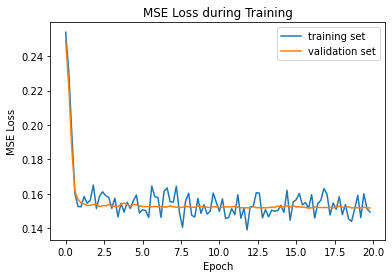

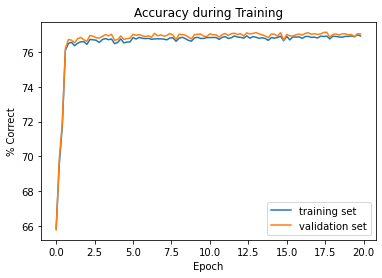

In [27]:
t = np.arange(0, num_epochs, 0.2)

plt.figure()
plt.title('MSE Loss during Training')
plt.plot(t, train_loss, label='training set')
plt.plot(t, valid_loss, label='validation set')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
plt.title('Accuracy during Training')
plt.plot(t, train_acc*100, label='training set')
plt.plot(t, valid_acc*100, label='validation set')
plt.ylabel('% Correct')
plt.xlabel('Epoch')
plt.legend()

In [26]:
test_me(model, test_loader)[0]

tensor(0.7662)